In [2]:
import numpy as np
from sklearn.gaussian_process import GaussianProcess

data = np.loadtxt('../Data/models.dat')
import mpld3
import matplotlib
import matplotlib.pyplot as pl
import corner
import copy
mpld3.enable_notebook()
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12  # that's default image size for this interactive session
pylab.rcParams['font.size'] = 16

import george
import george.kernels as kernels
import emcee
import corner

In [3]:
print(np.shape(data))

#There are 270 tracks, each of which is 400 steps long. These have all been loaded in
tracks = dict()
for i in range(270):
    tracks[i] = data[0+i*400:400+i*400,0:46]

#Now we just pick out the tracks that have initial mass of 1.7 Msun, and initial metalicity 0.014.
#There are nine of these.
m11p7 = dict()
for i in range(9):
    m11p7[i] = tracks[i]

(108000, 46)


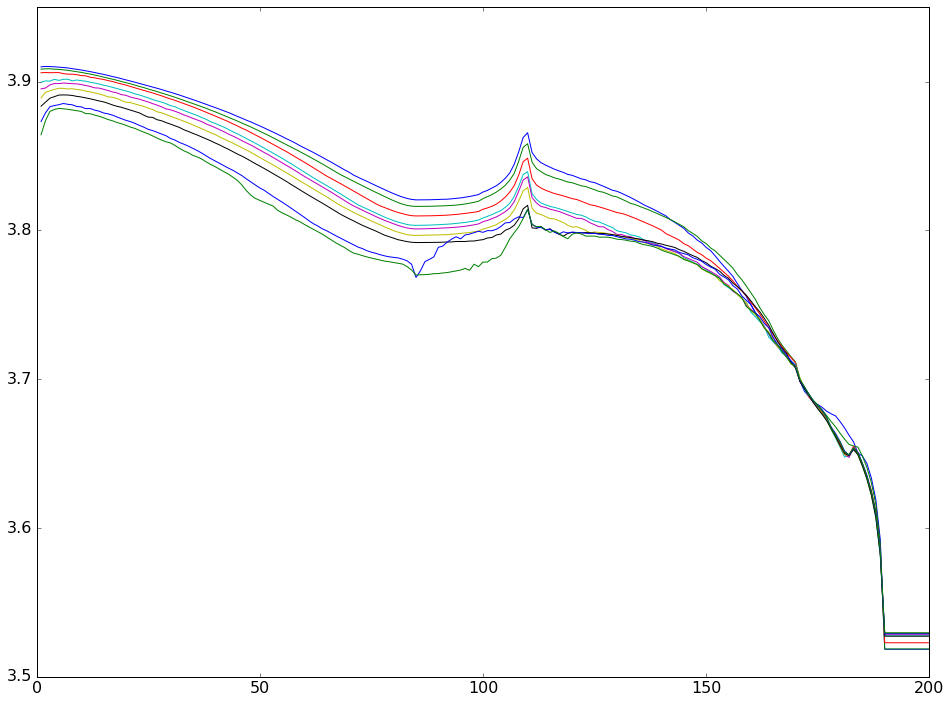

In [4]:
#Now we select just the first 200 time steps to interpolate over.
playdata = dict()
for i in range(9):
    playdata[i] = m11p7[i][0:200]
x = np.linspace(1,200,200)

#and plot the effective temperature as a function of time for the selected simulations
for i in range(9):
    pl.plot(playdata[i][:,3],playdata[i][:,7])
pl.show()

In [88]:
#Ok, so that has picked out nine tracks each with the same mass and metalicity, but varying
#the spin. Now use the predicted log(Teff) to interpolate log(Teff) over all possible values of spin.


dataobs = dict()
omegaobs = dict()
datatest = dict()
omegatest = dict()
massobs = dict()


for i in range(200):
    dataobs[i] = [playdata[0][i,4],playdata[1][i,4],playdata[4][i,4],playdata[7][i,4],playdata[8][i,4],playdata[2][i,4],playdata[3][i,4],playdata[5][i,4],playdata[6][i,4]]
    omegaobs[i] = [playdata[0][i,2],playdata[1][i,2],playdata[4][i,2],playdata[7][i,2],playdata[8][i,2],playdata[2][i,2],playdata[3][i,2],playdata[5][i,2],playdata[6][i,2]]
    massobs[i] = [playdata[0][i,1],playdata[1][i,1],playdata[4][i,1],playdata[7][i,1],playdata[8][i,1],playdata[2][i,1],playdata[3][i,1],playdata[5][i,1],playdata[6][i,1]]

#What's in these lists? The first number gives the track number - there are 9 of those in playdata. The second
#'number,' which is i, gives the time stamp. 
#The third number gives the omega parameter, for omegaobs, or
# the observable we're interpolating over, for dataobs. In this case, the observable is the log of the effective temp.

XT = dict()
XT2 = dict()
Teff = dict()

#Now we're just setting things up to feed into the GP interpolator. The values to be interpolated are the observed
#value, across the range of omegas. There are 200 time steps. These are delineated by [i]. But *at each i* there is 
#a vector, for omega this contains the points of omega that are observed. For data this contains
#the values at each of those. So y[100] is the 9-d vector containing the observed values at the 9-d vector in X. This 
#all pertains to the time step 100.
for i in range(200):
    XT[i] = np.atleast_2d(np.asarray(omegaobs[i])).T
    XT2[i] = np.atleast_2d(np.asarray(massobs[i])).T
    Teff[i] = np.asarray(dataobs[i])

add = np.random.normal(0,0.5,len(XT2[0]))
input2 = XT2[0].flatten()

input2 += add
input1 = XT[0].flatten()

output = Teff[0].flatten()

t = np.zeros((100,2))

#t[:,0] = np.tile(np.ones(100),100)
#dummy_y = np.linspace(-0.5,3.0,100)
#for ii in range(len(dummy_y)):
#    t[ii*100:(ii+1)*100,1] = dummy_y[ii]
    
xx = np.linspace(-1.0,1.0,10)
yy = np.linspace(0,1.0,10)
X, Y = np.meshgrid(xx,yy)

t[:,0] = X.flatten()
t[:,1] = Y.flatten()
print input2, input1, output

[-0.30539244 -0.14651002  0.96934098  0.15058399  0.47629103  0.01352594
  0.0923678   0.44645472  0.21951488] [ 0.    0.1   0.6   0.9   0.95  0.3   0.5   0.7   0.8 ] [ 13450000.7713107  13517049.2454116  14155890.3262268  14646907.1700689
  14929736.9098904  13806304.5860135  14293906.4458855  14155890.3262268
  14360435.1742239]


In [5]:
# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
# So y[0] is at omega = 0, y[1] is at omega = 1/100, etc.
x = np.atleast_2d(np.linspace(0, 1, 100)).T

# Instanciate a Gaussian Process model
print 'Scikit instantition:'
%timeit gp = GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1, random_start=100)
gp = GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1, random_start=100)
Teff_pred = dict()
sigmaT = dict()

print 'Scikit fitting:'
%timeit gp.fit(XT[0],testdata)

# Make the prediction on the meshed x-axis (ask for MSE as well)
print 'Scikit Prediction:'
%timeit Teff_pred[i], MSE = gp.predict(x, eval_MSE=True)

Scikit instantition:
The slowest run took 4.13 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.94 µs per loop
Scikit fitting:
1 loops, best of 3: 431 ms per loop
Scikit Prediction:
1000 loops, best of 3: 573 µs per loop


In [82]:
inputs = zip(input1, input2)
inputs = np.array(inputs)
print inputs, output

# Set up the Gaussian process.
k = 1.0 * kernels.ExpSquaredKernel([0.05,0.05],ndim=2)
gp = george.GP(k)

[[ 0.         -0.82285753]
 [ 0.1         0.3868745 ]
 [ 0.6        -0.73883094]
 [ 0.9         0.11492377]
 [ 0.95        0.23182876]
 [ 0.3         0.09751434]
 [ 0.5         0.36353516]
 [ 0.7        -0.88528284]
 [ 0.8         0.71071822]] [ 13450000.7713107  13517049.2454116  14155890.3262268  14646907.1700689
  14929736.9098904  13806304.5860135  14293906.4458855  14155890.3262268
  14360435.1742239]


In [85]:
print 'George fitting:'
%timeit gp.compute(inputs)


George fitting:
The slowest run took 7.12 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 210 µs per loop


In [96]:
mu, cov = gp.predict(output,t)
print mu

[  1.31266327e+01   1.08536240e+03   3.54312357e+04   4.79903506e+05
   2.88145264e+06   8.02452682e+06   1.06420990e+07   8.98995508e+06
   1.05286638e+07   1.02228053e+07   2.57207754e+01   2.12740274e+03
   6.75355072e+04   8.52691527e+05   4.56468414e+06   1.12793845e+07
   1.41251761e+07   1.20954071e+07   1.37972926e+07   1.31312863e+07
   4.15066332e+01   3.40302714e+03   1.05639401e+05   1.26996192e+06
   6.21773803e+06   1.37021294e+07   1.60620939e+07   1.39742340e+07
   1.52324026e+07   1.38358813e+07   5.26786445e+01   4.29603892e+03
   1.31672853e+05   1.53780421e+06   7.09902175e+06   1.42927755e+07
   1.57960350e+07   1.42868258e+07   1.50711080e+07   1.26117751e+07
   5.23364690e+01   4.25588897e+03   1.29545317e+05   1.48867929e+06
   6.63309027e+06   1.25599057e+07   1.34329772e+07   1.34551623e+07
   1.46828241e+07   1.10495288e+07   4.06596561e+01   3.30132305e+03
   1.00119292e+05   1.14040893e+06   4.97959980e+06   9.09576194e+06
   9.86000664e+06   1.21078084e+07

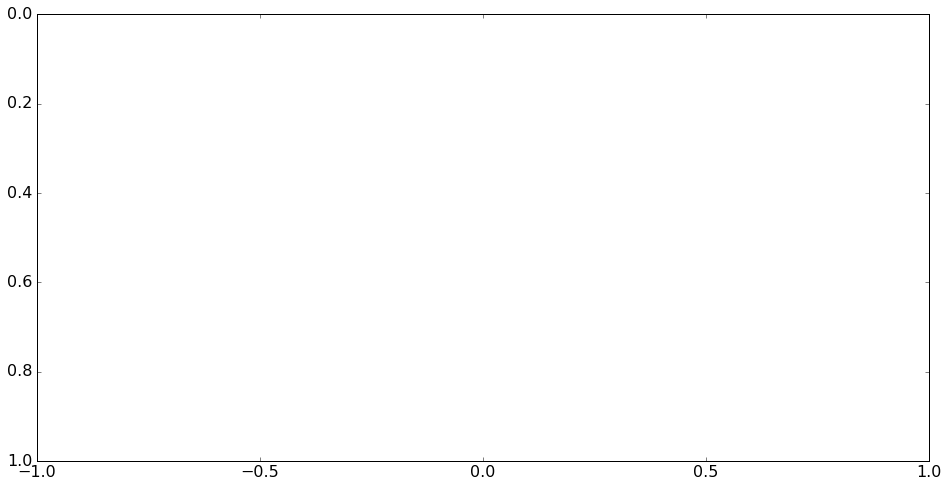

In [95]:
pl.plot(mu,)